# Preparation

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [9]:
import STAGATE

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [11]:
input_dir = '/home/zbdc/github/Data/Adult_Mouse_Brain/10x_Visium'

In [12]:
adata = sc.read_visium(path=input_dir, count_file='V1_Adult_Mouse_Brain_Coronal_Section_1_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [13]:
adata

AnnData object with n_obs × n_vars = 2903 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [14]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

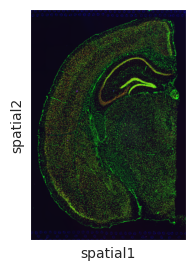

In [15]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires")

------Calculating spatial graph...
The graph contains 16982 edges, 2903 cells.
5.8498 neighbors per cell on average.


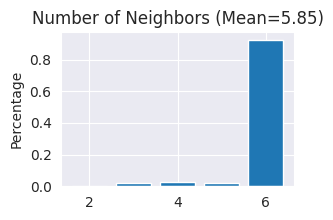

In [16]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=300)
STAGATE.Stats_Spatial_Net(adata)

In [ ]:
adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2,
                              n_epochs=1000, save_attention=True)

Size of Input:  (2903, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2023-10-23 13:38:39.046678: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-10-23 13:38:39.060111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2023-10-23 13:38:39.064748: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5639d3abb130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-23 13:38:39.064768: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-23 13:38:39.066694: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-10-23 13:38:39.204125: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5639d3b35db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 13:38:39.204149: I tensorflow/compil

------Pre-clustering using louvain with resolution=0.20
------Pruning the graph...
16982 edges before pruning.
15058 edges after pruning.


  2%|▎         | 25/1000 [00:05<03:39,  4.45it/s]

In [ ]:
# pre-clustering result
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color="expression_louvain_label", size=1.5, title='pre-clustering result')

In [ ]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

In [ ]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896',
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

# Visualization of the attention layer

In [ ]:
import matplotlib as mpl
import networkx as nx

In [ ]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [ ]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [ ]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))

In [ ]:
labels = nx.get_edge_attributes(G_atten,'weight')

In [ ]:
fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)

ax.set_axis_off()

# Running STAGATE without cell type-aware module (for comparison)

In [ ]:
adata = STAGATE.train_STAGATE(adata, alpha=0, n_epochs=1000, save_attention=True)

In [ ]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

In [ ]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896',
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

# Visualization of the attention layer (without cell type-aware module)

In [ ]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [ ]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [ ]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))

In [ ]:
labels = nx.get_edge_attributes(G_atten,'weight')

In [ ]:
fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)

ax.set_axis_off()
